## Import Packages

In [35]:
import pathlib 
from glob import glob 
import PIL

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import tensorflow as tf 

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import Dataset

In [12]:
data_local_dir = 'train_data'    #rename to where data is located on your local machine 
data_dir = pathlib.Path(data_local_dir) 

In [13]:
normal_xray = list(data_dir.glob('NORMAL/*.jpeg'))
pneum_xray = list(data_dir.glob('PNEUMONIA/*.jpeg'))

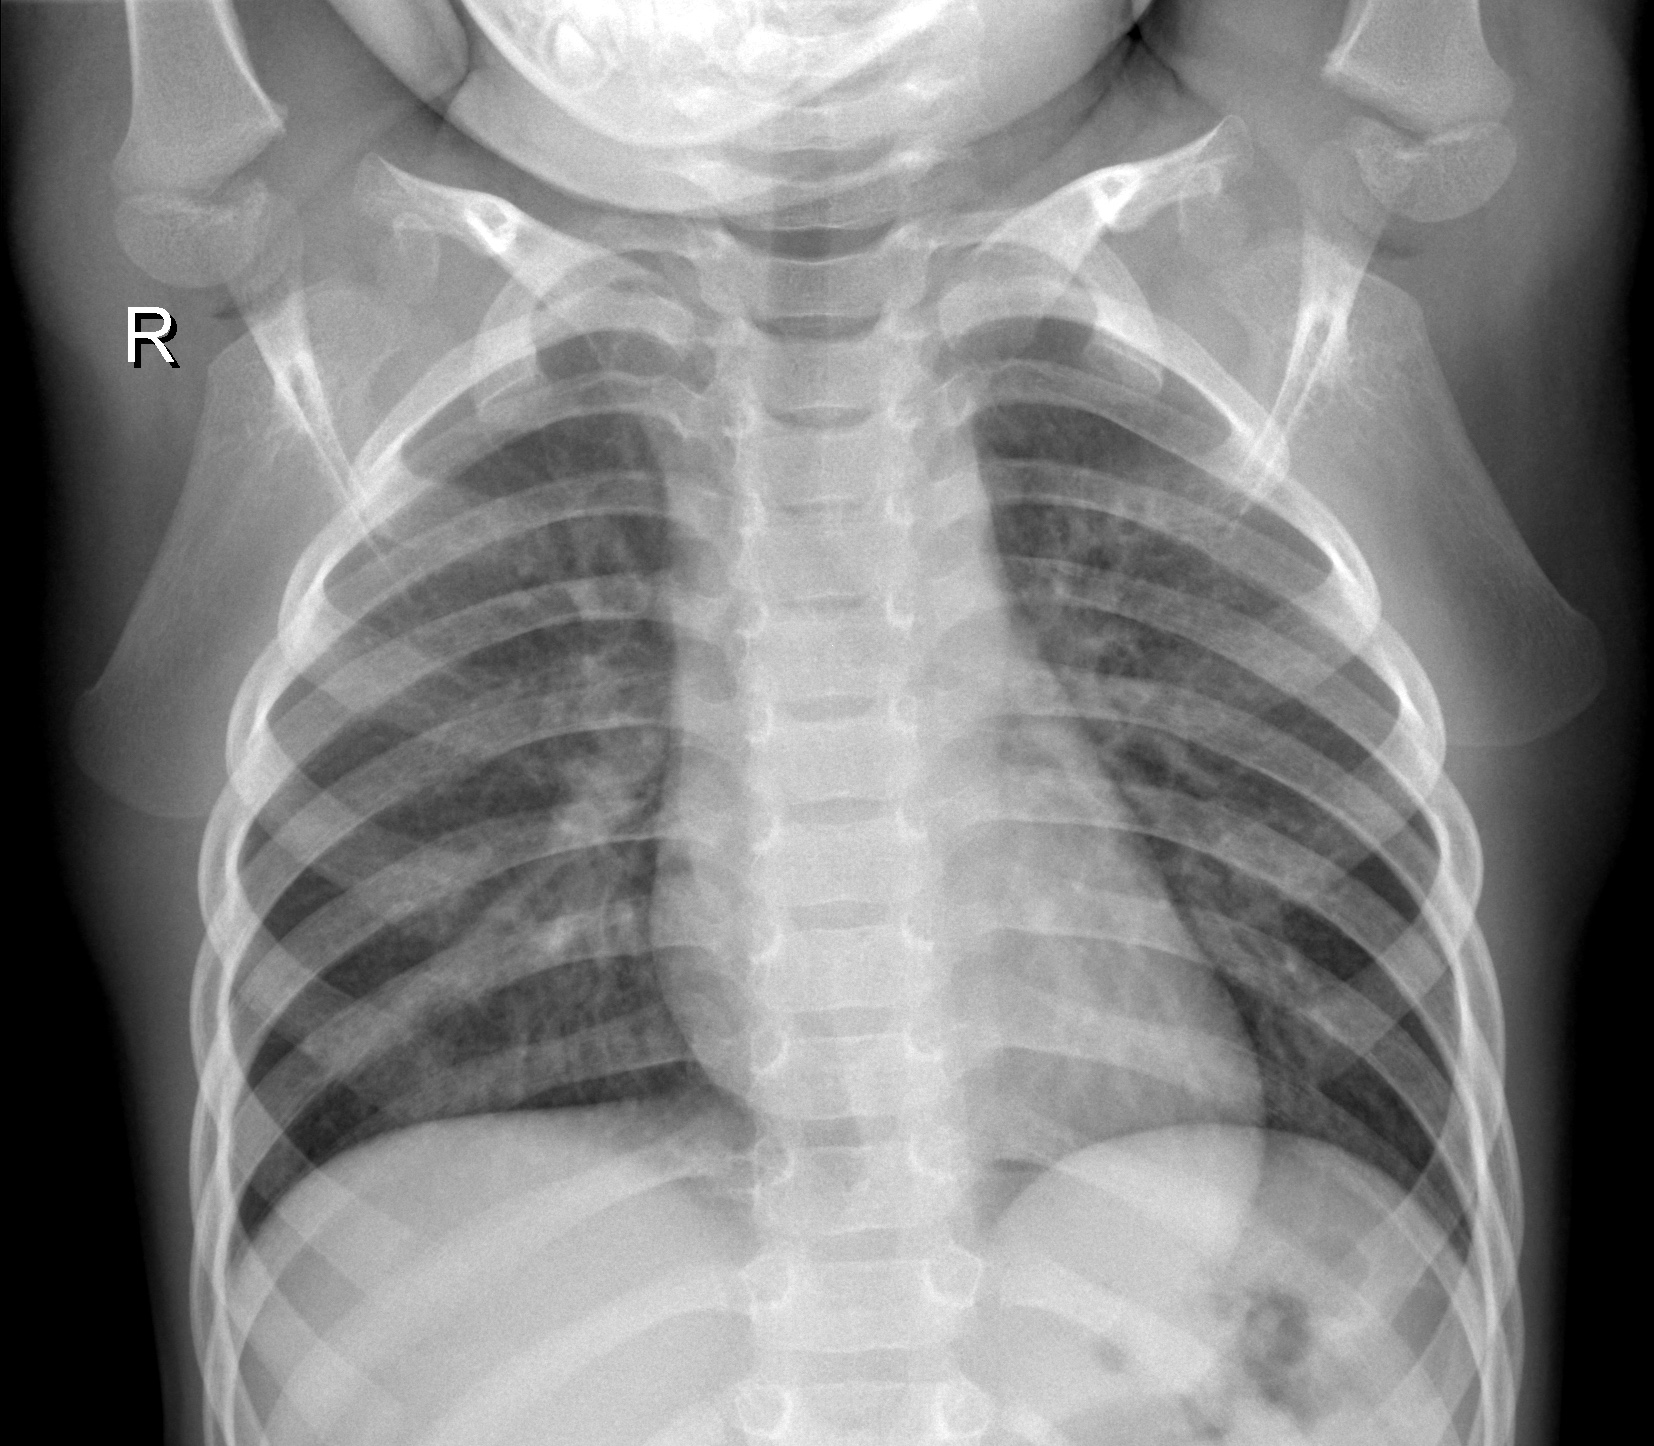

In [19]:
normal_im = PIL.Image.open(str(normal_xray[0]))
normal_im

In [20]:
normal_im.size

(1654, 1446)

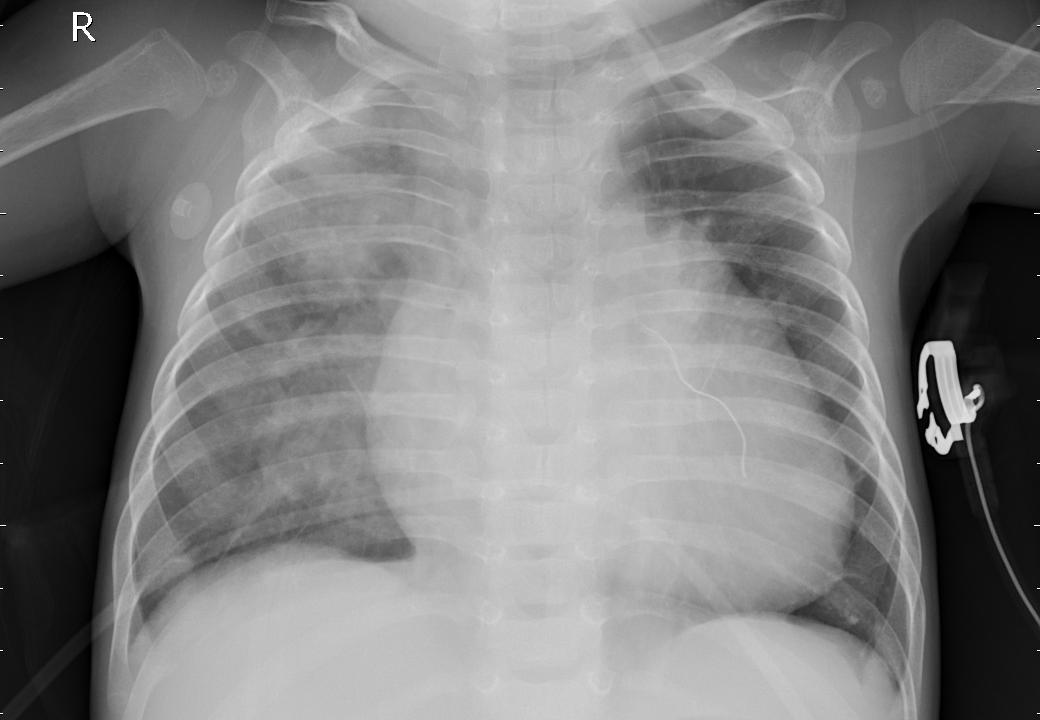

In [22]:
pneum_im = PIL.Image.open(str(pneum_xray[0]))
pneum_im

In [23]:
pneum_im.size

(1040, 720)

In [24]:
pneum_im2 = PIL.Image.open(str(pneum_xray[1]))
pneum_im2.size

(1128, 640)

The images have all different sizes, so the image sizes will have to be standardized. 

In [29]:
#find mininimum width and height in our images
min_w, min_h = 10000, 10000
for pic in (normal_xray + pneum_xray):
    with PIL.Image.open(pic) as img:
        width, height = img.size
        min_w = min( min_w, width)
        min_h = min( min_h, height)

print(min_w, min_h)

384 127


In [48]:
data = []
for pic in (normal_xray + pneum_xray):
    with PIL.Image.open(pic) as img:
        width, height = img.size
        asp_ratio = width/height
        data.append([pic, width, height, asp_ratio])

img_df = pd.DataFrame(data, columns = ['path','width', 'height', 'aspect ratio'])
img_df

,path,width,height,aspect ratio
0,train_data/NORMAL/NORMAL-2552119-0002.jpeg,1654,1446,1.143845
1,train_data/NORMAL/NORMAL-7298141-0001.jpeg,1674,1144,1.463287
2,train_data/NORMAL/NORMAL-3411116-0002.jpeg,1414,1164,1.214777
3,train_data/NORMAL/NORMAL-1619233-0001.jpeg,1288,1008,1.277778
4,train_data/NORMAL/NORMAL-7327513-0001.jpeg,1850,1746,1.059565
...,...,...,...,...
5227,train_data/PNEUMONIA/BACTERIA-3395038-0001.jpeg,1904,1744,1.091743
5228,train_data/PNEUMONIA/BACTERIA-6952717-0001.jpeg,1392,824,1.689320
5229,train_data/PNEUMONIA/VIRUS-463487-0002.jpeg,1352,1080,1.251852
5230,train_data/PNEUMONIA/BACTERIA-4343805-0001.jpeg,1048,856,1.224299


<AxesSubplot:>

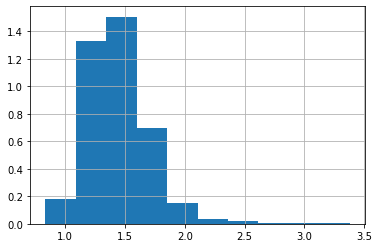

In [45]:
img_df['aspect ratio'].hist(density = True)

In [46]:
img_df.describe()

,width,height,aspect ratio
count,5232.000000,5232.000000,5232.000000
mean,1320.695336,968.181384,1.440047
std,355.024600,378.542729,0.257115
min,384.000000,127.000000,0.835391
25%,1056.000000,688.000000,1.257206
50%,1284.000000,888.000000,1.411426
75%,1552.000000,1187.750000,1.583333
max,2916.000000,2663.000000,3.378788


In [49]:
img_df[img_df['width'] == 384]

,path,width,height,aspect ratio
4912,train_data/PNEUMONIA/VIRUS-355597-0002.jpeg,384,127,3.023622


Resize to smallest size with aspect ratio of 1.45 

In [50]:
350/1.45

241.3793103448276

In [51]:
img_width = 350 
img_height = 240

## Create Dataset

In [52]:
batch_size = 32
img_height = 240
img_width = 350

In [53]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed = 27,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5232 files belonging to 2 classes.
Using 3663 files for training.


In [54]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed = 27,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5232 files belonging to 2 classes.
Using 1569 files for validation.


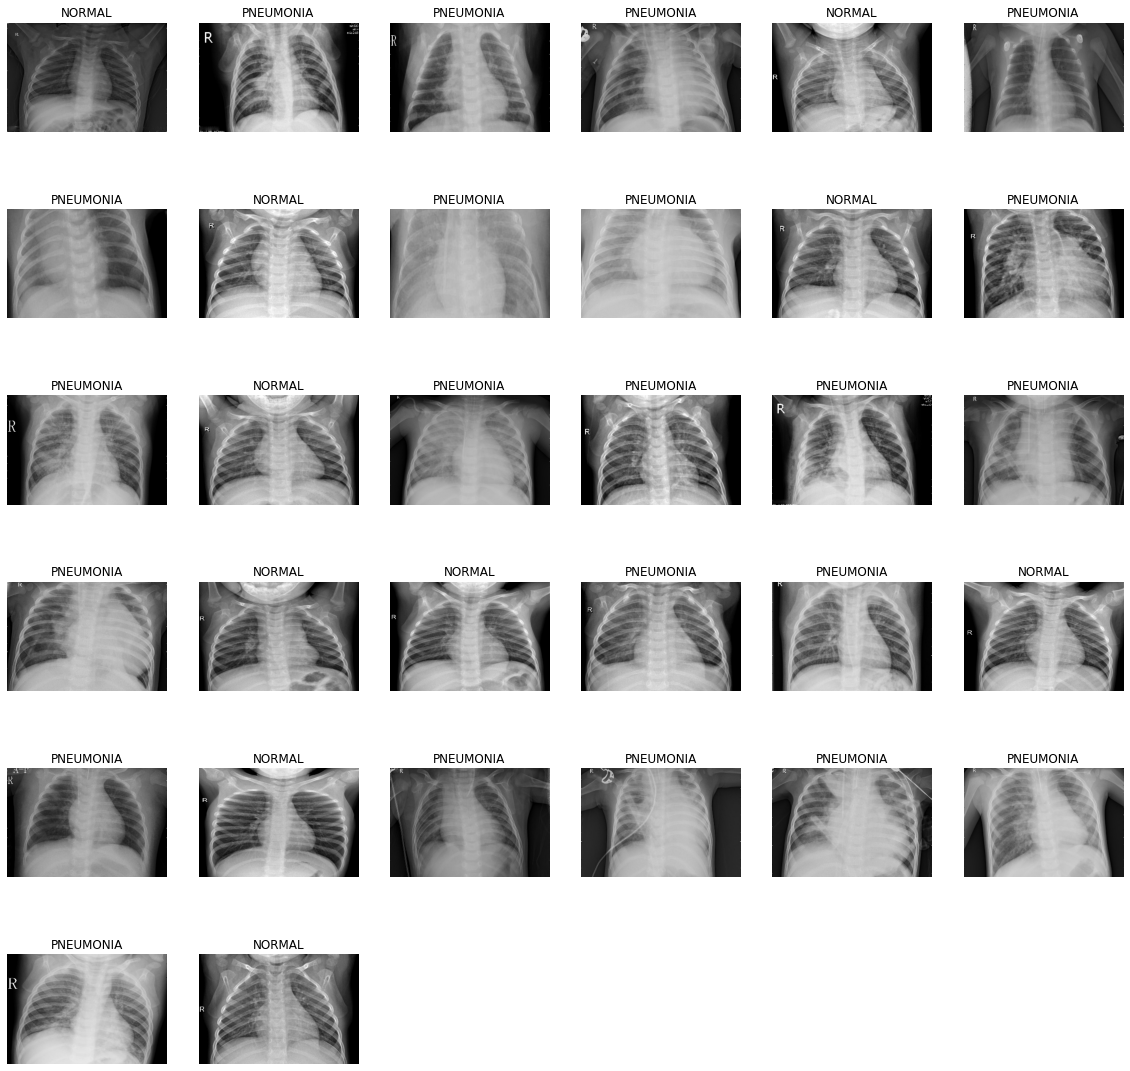

In [58]:
plt.figure(figsize=(20, 20))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [68]:
image_batch, labels_batch = next(iter(train_ds))
print(image_batch.shape)
print(labels_batch.shape)

(32, 240, 350, 3)
(32,)


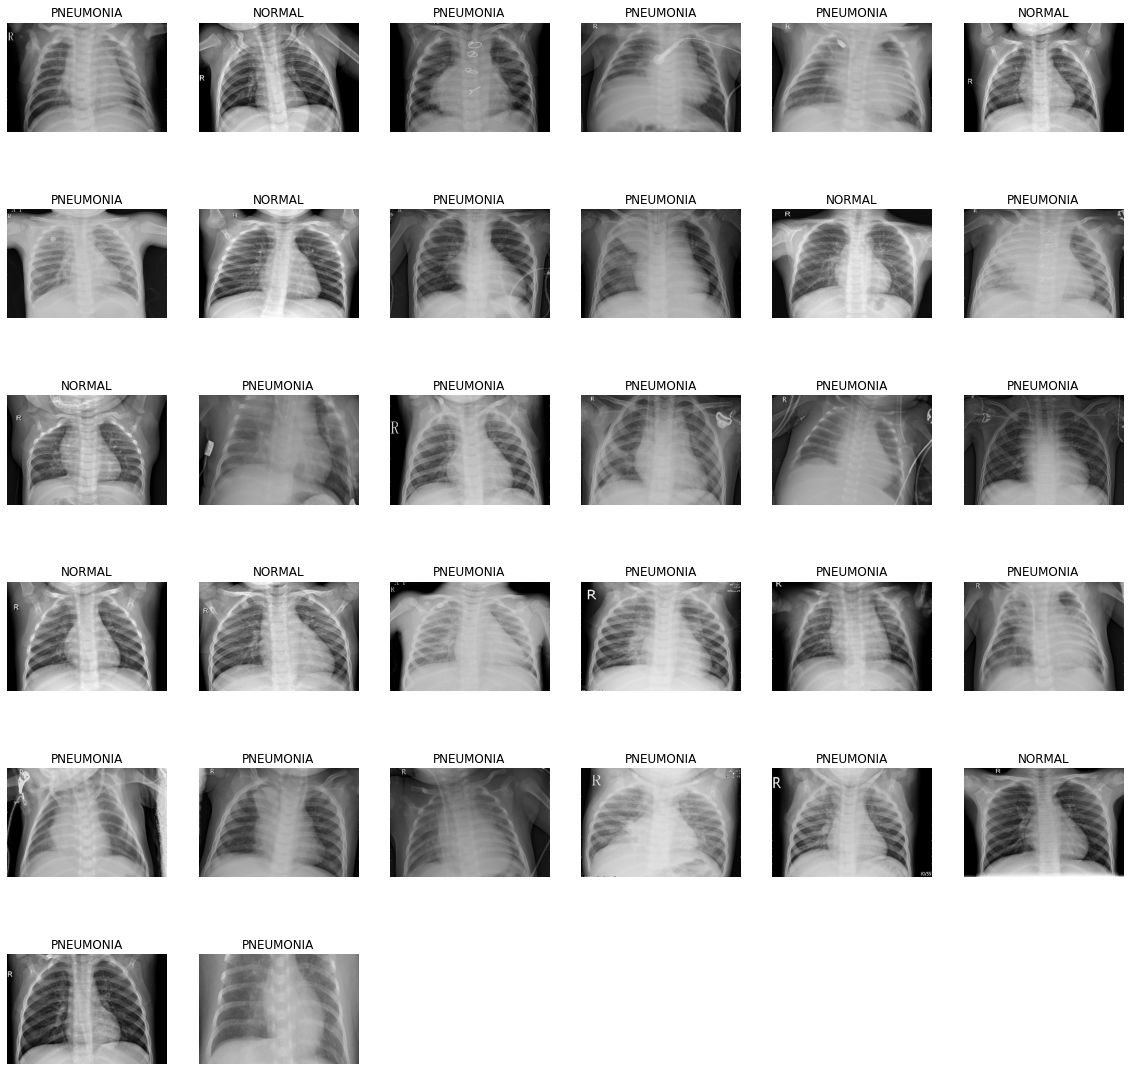

In [57]:
plt.figure(figsize=(20, 20))
class_names = test_ds.class_names
for images, labels in test_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [69]:
image_batch, labels_batch = next(iter(train_ds))
print(image_batch.shape)
print(labels_batch.shape)

(32, 240, 350, 3)
(32,)


In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [77]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [84]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(image_batch.shape)
print(labels_batch.shape)
print(np.min(first_image), np.max(first_image))

(32, 240, 350, 3)
(32,)
0.0 1.0


## CNN Model

### Basic Model

In [132]:
num_classes = len(class_names)

basic_model1_bin = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [133]:
basic_model1_bin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [134]:
basic_model1_bin.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 240, 350, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 240, 350, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 120, 175, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 120, 175, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 60, 87, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 87, 64)       

In [135]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
checkpoint = ModelCheckpoint(filepath='/tmp/checkpoint', verbose=1, save_best_only=True)
logger_bm1 = CSVLogger('log_basic_model1.csv', append=True, separator=' ')

In [141]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.weights_monitor = open("weights.txt", "w+")
            
        
    # learning rate scheduler is called at the end of each epoch. learning rate decreases if needed
    def on_epoch_end(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        # keys = list(logs.keys())
        # print("keys",keys)
        val_acc = logs.get("val_binary_accuracy")
        scheduled_lr = self.schedule(lr, val_acc)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
         
    #first and last convolutional layers' and dense layer's weights are saved at the beginning of each epoch
    def on_epoch_begin(self, epoch, logs=None):
        epoch_str = "beginning of epoch : "+ str(epoch)
        self.weights_monitor.write(epoch_str)
        self.weights_monitor.write(str(basic_model1_bin.get_layer("conv2d").weights))
        self.weights_monitor.write(str(basic_model1_bin.get_layer("conv2d_1").weights))
        self.weights_monitor.write(str(basic_model1_bin.get_layer("dense_1").weights))
          
def learning_rate_scheduler(lr, val_acc):
    global count
    global previous_acc
      
    if val_acc <= previous_acc:
        #  print("acc ", val_acc, "previous acc ", previous_acc)
        count += 1
    else:
        previous_acc = val_acc
        count = 0
        
    if count >= 10:
        print("acc doesnt improve for 10 epoch, learnin rate decreased by /10")
        count = 0
        lr /= 10
        print("new learning rate:", lr)     
           
    return lr

In [142]:
basic_model1_bin_fit = basic_model1_bin.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25, 
    callbacks =[earlystopping, checkpoint, logger_bm1, CustomLearningRateScheduler(learning_rate_scheduler)]
)

ValueError: No such layer: conv2d. Existing layers are: ['rescaling_4', 'conv2d_21', 'max_pooling2d_15', 'conv2d_22', 'max_pooling2d_16', 'conv2d_23', 'max_pooling2d_17', 'flatten_5', 'dense_13', 'dense_14'].

In [99]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal")
basic_model2 = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[240, 350, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                             kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                             kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [ ]:
basic_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [100]:
basic_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 240, 350, 64)      9472      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 120, 175, 64)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 120, 175, 128)     73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 120, 175, 128)     147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 60, 87, 128)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 87, 256)      

In [103]:
basic_model2_fit = basic_model2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10, 
    callbacks =[earlystopping]
)

Epoch 1/10
115/115 [==============================] - 1043s 9s/step - loss: 0.7222 - accuracy: 0.7851 - val_loss: 0.3633 - val_accuracy: 0.8611
Epoch 2/10
115/115 [==============================] - 1147s 10s/step - loss: 0.4893 - accuracy: 0.8327 - val_loss: 0.3506 - val_accuracy: 0.8795
Epoch 3/10
115/115 [==============================] - 1046s 9s/step - loss: 0.3859 - accuracy: 0.8602 - val_loss: 0.3213 - val_accuracy: 0.8866
Epoch 4/10
115/115 [==============================] - 945s 8s/step - loss: 0.3479 - accuracy: 0.8711 - val_loss: 0.3184 - val_accuracy: 0.8738
Epoch 5/10
 62/115 [===============>..............] - ETA: 6:17 - loss: 0.4496 - accuracy: 0.8372

KeyboardInterrupt: 